# spectra_post 
Jupyter notebook for post processing spectra files from WinSpec

Uses spectroscopy.py library
written by Peter Ningren Han;
modified by Nili Persits and Jaehwan Kim.

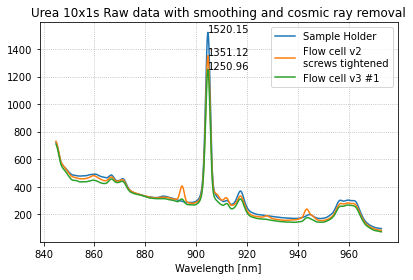

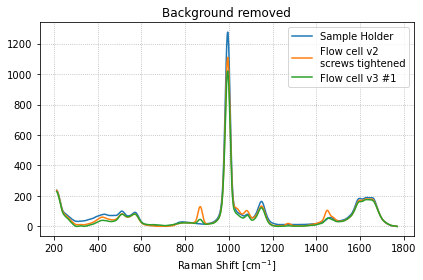

In [6]:
%reset -f

import matplotlib.pyplot as plt
from speclib.spectroscopy import *

laser=830.0
filename_dic = {
    'Sample Holder':       './data/20210128 Flowcell v3 test/sample-holder_urea_10x1s8',
#     'Flow cell v2':        './data/20210125 Flowcell v2 test/Flow_cell_urea_10x1s1',
#     'Flow cell with 70% ethanol': './data/20210125 Flowcell v2 test/Flow_cell_ethanol70percemt_10x1s3',
    'Flow cell v2\nscrews tightened':        './data/20210126 Flowcell v2 test 2/urea_10x1s10',
#     'Flow cell with 70% ethanol': './data/20210126 Flowcell v2 test 2/ethanol70pc_10x1s5',
    
    'Flow cell v3 #1':       './data/20210128 Flowcell v3 test/FCv3_urea_10x1s1',    
#     'Flow cell v3 #2':       './data/20210128 Flowcell v3 test/FCv3_urea_10x1s2',    
}

data_dic = {}
for key, file_name in filename_dic.items():
    try:
        X, wave = load_txt_new(file_name=file_name, if_plot=False)
    except:
        X, wave = load_txt_auto(file_name=file_name, if_plot=False)
    X_sig, X_bkg = background_remove_full(X, order=3, basis_type='poly', method='Lieber')    
    waveshift = wave_2_waveshift(wave, laser)
    
    data_dic[key] = [waveshift, X_sig[0], wave, X]


plt.figure()
for key, data in data_dic.items():
    plt.plot(data[2], data[3], label=key)
    peak = np.max(data[3])
    peak_wave = data[2][np.argmax(data[3])]
    SBR = peak / data[3][np.abs(data[2]-880.0)<0.1] # signal to background peak at 880nm
#     print(SBR)
#     plt.annotate('Peak count: {:g}\nSignal to 880nm background: {:g}'.format(peak, np.mean(SBR)), xy=(data[2][np.argmax(data[3])], peak))
    plt.annotate('{:g}'.format(peak), xy=(peak_wave, peak))
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.grid(True, linestyle=':')
plt.title('Urea 10x1s Raw data with smoothing and cosmic ray removal')
plt.tight_layout()
plt.show()


plt.figure()
for key, data in data_dic.items():
    plt.plot(data[0], data[1], label=key)
plt.legend()
plt.xlabel('Raman Shift [cm$^{-1}$]')
plt.grid(True, linestyle=':')
plt.title('Background removed')
plt.tight_layout()
plt.show()
